<a href="https://colab.research.google.com/github/Wandering-Sci/Python-Samples/blob/main/PyTorch_NN_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PyTorch example on Iris dataset with K-Fold Cross-Validation**

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_iris
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# For CUDA (if using a GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Ensures deterministic behavior

# Load iris dataset
iris = load_iris()
iris_x = torch.tensor(iris.data, dtype=torch.float32)
iris_y = torch.tensor(iris.target, dtype=torch.long)

dataset = TensorDataset(iris_x, iris_y)

In [3]:
# Creating NN Model class
class nnModel(nn.Module):
  def __init__(self, input_size = 4, fc1 = 8, output_size = 3):
    super().__init__()
    self.fc1 = nn.Linear(input_size, fc1)
    self.out = nn.Linear(fc1, output_size)

  def forward(self, data):
    data = F.relu(self.fc1(data))
    data = self.out(data)
    return data

In [9]:
# Initializing KFold cross-validation
folds_count = 5
kf = KFold(n_splits = folds_count, shuffle = True, random_state = SEED)

kf_result = []
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
  # Split folds
  train_subset = torch.utils.data.Subset(dataset, train_idx)
  test_subset = torch.utils.data.Subset(dataset, test_idx)
  train_loader = DataLoader(train_subset, batch_size = 16, shuffle = True)
  test_loader = DataLoader(test_subset, batch_size = 16, shuffle = False)

  # Initialize model, loss function, optimizer
  model = nnModel()
  criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0, 1.5])) # because we have imbalance dataset
  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  # Training
  for epoch in range(10):
    model.train()
    for batch in train_loader:
      inputs, targets = batch
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

  # Evaluation
  correct = 0
  total = 0
  all_targets = []
  all_predictions = []
  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      inputs, targets = batch
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == targets).sum().item()
      total += targets.size(0)
      all_targets.extend(targets.tolist())
      all_predictions.extend(predicted.tolist())

  accuracy = correct / total
  kf_result.append(accuracy)
  print(f"Accuracy for fold {fold + 1}: {accuracy:.2f}")

Accuracy for fold 1: 0.53
Accuracy for fold 2: 0.50
Accuracy for fold 3: 0.43
Accuracy for fold 4: 0.47
Accuracy for fold 5: 0.70


In [10]:
# Overall performance
print(f"Mean Accuracy over {folds_count} folds: {sum(kf_result) / len(kf_result):.2f}")

Mean Accuracy over 5 folds: 0.53


In [11]:
print(classification_report(all_targets,all_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.83      0.45      0.59        11
           2       0.58      0.92      0.71        12

    accuracy                           0.70        30
   macro avg       0.80      0.70      0.71        30
weighted avg       0.77      0.70      0.69        30



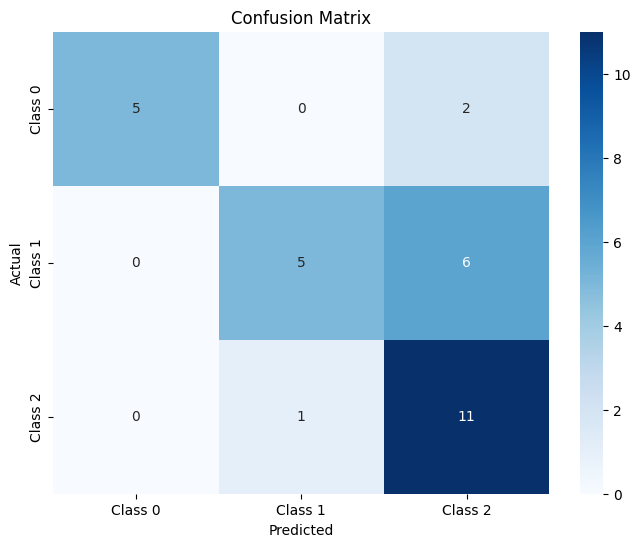

In [12]:
# confusion matrix
cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()